# Libraries

In [1]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from math import floor
import seaborn as sns
import yfinance as yf
from bandit_library import *

# Defining Inputs

In [85]:
##INTERVAL AND TRADING PERIOD##

interval = '1d'
tau = 200
m = 100

trade_start_time = datetime.datetime(2023,1,15,17,30)

if interval == '1d':
    hist_start_time = trade_start_time - datetime.timedelta(days=tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=m)
if interval == '1wk':
    hist_start_time = trade_start_time - datetime.timedelta(days=7*tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=7*m)
    
hist_end_time = trade_end_time

##INTERVAL AND TRADING PERIOD##

In [21]:
##STOCKS##

tickers = ['AC.PA','ALO.PA','AI.PA','ATO.PA','CAP.PA','ORA.PA','RI.PA','TTE.PA',
           'PINR.PA','SW.PA','SU.PA','BN.PA','PAASI.PA','PAEEM.PA','ML.PA','SK.PA']
n_assets = len(tickers)

##STOCKS##

In [22]:
data = Data(tickers)
hist_returns = data.get_data(hist_start_time,hist_end_time,interval)

Asset : ['AC.PA', 'ALO.PA', 'AI.PA', 'ATO.PA', 'CAP.PA', 'ORA.PA', 'RI.PA', 'TTE.PA', 'PINR.PA', 'SW.PA', 'SU.PA', 'BN.PA', 'PAASI.PA', 'PAEEM.PA', 'ML.PA', 'SK.PA']
[*********************100%***********************]  16 of 16 completed
start date   : 2022-02-27 17:30:00
start date   : 2022-12-24 17:30:00


# Brief Co-Dependence Analysis

Text(0.5, 1.0, 'Covariance Matrix')

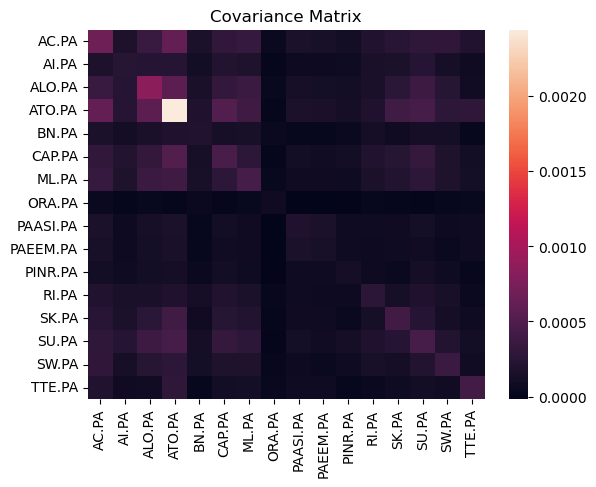

In [83]:
sns.heatmap(hist_returns.cov())
plt.title('Covariance Matrix')

Text(0.5, 1.0, 'Spearman Correlation')

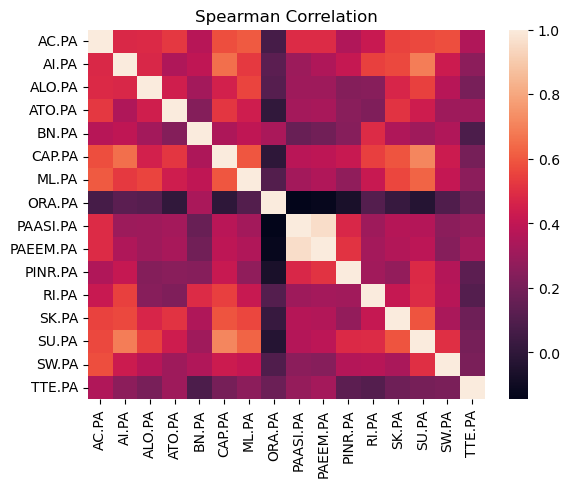

In [84]:
sns.heatmap(hist_returns.corr(method='spearman'))
plt.title('Spearman Correlation')

Let us compute the covariance matrix of our returns :

In [25]:
cov_matrix = get_cov(hist_returns)

This matrix is $\Sigma_k$ but we will need to eigen-decompose it .

We now estimate the average return $\mathbb{E}[\textbf{R}_k] \in \mathbb{R}_n $

 - $\tau$ represents the size of the training data 
 - Example : if we study an interval of 300 days, $\tau$ = 300
 - Our 'training' returns are in the interval $[k-\tau, k-1]$, hence the length is $k-1 - (k-\tau) + 1 = \tau$

NB : 
- hist_start_time = trading_start_time - $\tau$
- To ensure that the average return and the covariance matrix of assets returns $\Sigma_k$ are estimated by $(\textbf{R}_{k-\tau},..,\textbf{R}_{k-1})$

In [26]:
k=1

In [27]:
E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time)

The next step is to decomposse of the covariance matrix :

In [28]:
Lambda, H = eigen_decomposition(Sigma)
Lambdas = np.diag(Lambda)

- Lambda corresponds to $\Lambda_k$
- Lambdas is a numpy array containing all the eigenvalues (the diagonal of $\Lambda_k$)
- H corresponds to $\mathcal{H}_k$

Now we compute the renormalized similarity matrices and eigenvalues :

In [29]:
Lambda_norm, H_norm = normalization(n_assets,Lambda,H)
Lambdas_norm = np.diag(Lambda_norm)

In [30]:
Sigma_tilde, Lambda_tilde = np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm)),np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm))

- Lambda_tilde and Sigma_tilde corresponds to $\tilde{\Lambda_k}$
- H_norm corresponds to $\tilde{\mathcal{H}_k}$

We have a constructed a set of n uncorrelated portfolios with return $\textbf{H}_k^{T} \textbf{R}_k$

In [31]:
portfolio_returns = np.matmul(np.transpose(H),np.array(E_R))

At time $t_k$ the return of the i-th orthogonal portfolio is estimated as $\tilde{H_{k,i}}R_{k,i}$
              and the variance with $\tilde{\lambda_{k,i}}$                  

In [32]:
SR = get_sharpe_ratios(n_assets,H,Lambdas,E_R)
SR

array([ 15.07585955,  29.31010565,  40.26510709,  47.85564322,
        51.98065192,  57.59466938,  68.49132983,  71.37208193,
        73.8235465 ,  87.37572514,  91.27309628,  99.76673364,
       122.77733912, 132.96046112, 147.30711537, 538.31973632])

# All in One - Algorithm Orthogonal Bandit Portfolio

In [86]:
interval = '1wk'
tau = 50
m = 10
l = 8 #n_assets / 2 looks good for small n_assets

In [95]:
def run_obp(interval,l,m,tau):
    weights = []
    returns = []
    returnsEW = []
    CW_OBP_list =[]
    CW_EW_list=[]
    Theta = []
    choices_inf = l*[0]
    choices_sup = (n_assets-l)*[0]
    data = Data(tickers)
    hist_returns = data.get_data(hist_start_time,hist_end_time,interval)
    for k in range(1,m+1):
        #Step 1 : Estimate Average Return and Covariance Matrix of asset returns
        E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time)

        #Step 2 : Principal Component Decomposition 
        Lambda, H = eigen_decomposition(Sigma)
        Lambdas = np.diag(Lambda)

        #Step 3 : Normalize
        Lambda_norm, H_norm = normalization(n_assets,Lambda,H)
        Lambdas_norm = np.diag(Lambda_norm)
        Sigma_tilde, Lambda_tilde = np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm)),np.matmul(np.matmul(H_norm,Sigma),np.transpose(H_norm))

        #Step 4 : Compute the Sharpe Ratio of each arm
        SR = get_sharpe_ratios(n_assets,H,Lambdas,E_R)

        #Step 5 : Compute the adjusted reward function of each arm
        SR_inf,SR_sup,Lambda_inf,Lambda_sup,H_inf,H_sup = factor_decomposition(Lambda_norm,H_norm,SR,l)
        adjusted_rewards_inf = objective_function(n_assets,SR_inf,k,tau,choices_inf)
        adjusted_rewards_sup = objective_function(n_assets,SR_sup,k,tau,choices_sup)

        #Step 6 : Select an arm for each subset 
        arm_inf = ucb_policy(n_assets,SR_inf,k,tau,choices_inf)
        arm_sup = ucb_policy(n_assets,SR_sup,k,tau,choices_sup)
        choices_inf[arm_inf]+=1 #updating k_i
        choices_sup[arm_sup]+=1

        #Step 7 : Calculate the portfolio weights and return
        Thetak = np.diag(Lambda_inf)[arm_inf]/(np.diag(Lambda_inf)[arm_inf]+np.diag(Lambda_sup[:,l:])[arm_sup])
        Theta.append(Thetak)
        w_k = (1-Thetak)*H_inf[:,arm_inf] + Thetak*H_sup[:,arm_sup]
        weights.append(w_k)
        mu_k  = np.matmul(np.transpose(w_k),E_R)-1
    #     mu_k  = np.sum(w_k*E_R)-1  #both mu_k are equivalent 
        returns.append(mu_k)
        mu_k_EW = np.sum(E_R/n_assets)-1
    #     mu_k_EW = hist_returns[(hist_returns.index>trade_start_time+datetime.timedelta(days=k))&(hist_returns.index<trade_start_time+datetime.timedelta(days=k+1))].mean().mean()
        returnsEW.append(mu_k_EW)
        CW_OBP_list.append(np.product(np.array(returns)+1))
        CW_EW_list.append(np.product(np.array(returnsEW)+1))
    return(returns,returnsEW,CW_OBP_list,CW_EW_list,weights)




In [96]:
returns,returnsEW,CW_OBP_list,CW_EW_list,weights = run_obp(interval=interval,tau=tau,l=l,m=m)

Asset : ['AC.PA', 'ALO.PA', 'AI.PA', 'ATO.PA', 'CAP.PA', 'ORA.PA', 'RI.PA', 'TTE.PA', 'PINR.PA', 'SW.PA', 'SU.PA', 'BN.PA', 'PAASI.PA', 'PAEEM.PA', 'ML.PA', 'SK.PA']
[*********************100%***********************]  16 of 16 completed
start date   : 2022-06-29 17:30:00
start date   : 2023-04-25 17:30:00


In [120]:
mean_return = np.mean(np.array(returns)) # +1 if gross, nothing if net return
mean_return_ew = np.mean(np.array(returnsEW))
std = np.sqrt((1/(m-1))*np.sum((returns-mean_return)**2))
std_ew = np.sqrt((1/(m-1))*np.sum((returnsEW-mean_return_ew)**2))
CW_OBP = np.product(np.array(returns)+1)
CW_EW = np.product(np.array(returnsEW)+1)
print('PORTFOLIO INFOS')
print('------------')
print('OBP - Sharpe Ratio :',mean_return/std)
print('EW - Sharpe Ratio :',mean_return_ew/std_ew)
print('------------')
print('Cumulative Wealth OBP',CW_OBP)
print('Cumulative Wealth EW',CW_EW)

PORTFOLIO INFOS
------------
OBP - Sharpe Ratio : 0.29367938603415783
EW - Sharpe Ratio : 1.0908748979199974
------------
Cumulative Wealth OBP 2.0896045398554475
Cumulative Wealth EW 1.0843983136387874


Text(0.5, 1.0, 'Comparing OBP and EW Portfolios CW')

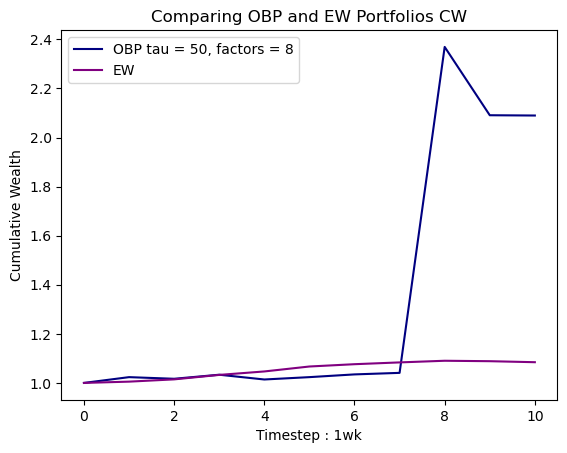

In [100]:
sns.lineplot(x=np.arange(0,m+1,1),y=[1]+CW_OBP_list,color='navy',label=f'OBP tau = {tau}, factors = {l}')
sns.lineplot(x=np.arange(0,m+1,1),y=[1]+CW_EW_list,color='purple',label='EW')
plt.ylabel('Cumulative Wealth')
plt.xlabel(f'Timestep : {interval}')
plt.title('Comparing OBP and EW Portfolios CW')

In [105]:
weights[6]

array([-0.10702343,  0.5994512 ,  0.07174324, -0.1538168 , -0.06420978,
        0.17227981,  0.10622725, -0.22961299, -0.1722043 , -0.27101624,
       -0.02248612,  0.27753652,  0.13890628, -0.00530205,  0.08309808,
        0.57642932])

In [103]:
weights[7]

array([  8.60035355, -30.87810938,  21.80389528,  20.10794574,
        -8.3703018 ,  -5.95946822,  -8.01025071,   1.86672977,
        -8.04952127, -10.71117151,   6.30516674,  -3.69527293,
        16.53847037, -10.67408082, -14.16828175,  26.29389694])

We observe a huge gap in weights over time ! high cost of short selling such quantities ! 